In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from matplotlib import pyplot as plt

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
plt.rcParams['font.family'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

In [2]:
%store -r fix_samples_data
%store -r threshold
%store -r cluster_1st

cluster = cluster_1st

In [3]:
# 对于每个类别进行判别
samples_features = cluster.iloc[:, 2:-1]
datetime_features = cluster[("时间", 'Unnamed: 1_level_1')]  # 时间性质
source_features = samples_features[samples_features.columns[[x for x in range(0, 7)]]]  # 原料性质
produc_features = samples_features[samples_features.columns[[x for x in range(7, 10)]]]  # 产品性质
manule_features = samples_features[samples_features.columns[[x for x in range(14, samples_features.shape[1])]]]  # 操作属性

In [4]:
# # 进行数据的标准化操作
# scaler = preprocessing.StandardScaler()
# scaler.fit(manule_features.to_numpy())
# manule_features[manule_features.keys()] = scaler.transform(manule_features)

# print(manule_features.reindex().shape)

# scaler.fit(produc_features.to_numpy())
# produc_features[produc_features.keys()] = scaler.transform(produc_features)

# print(produc_features.reindex().shape)

# scaler.fit(source_features.to_numpy())
# source_features[source_features.keys()] = scaler.transform(source_features)

# print(source_features.reindex().shape)

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

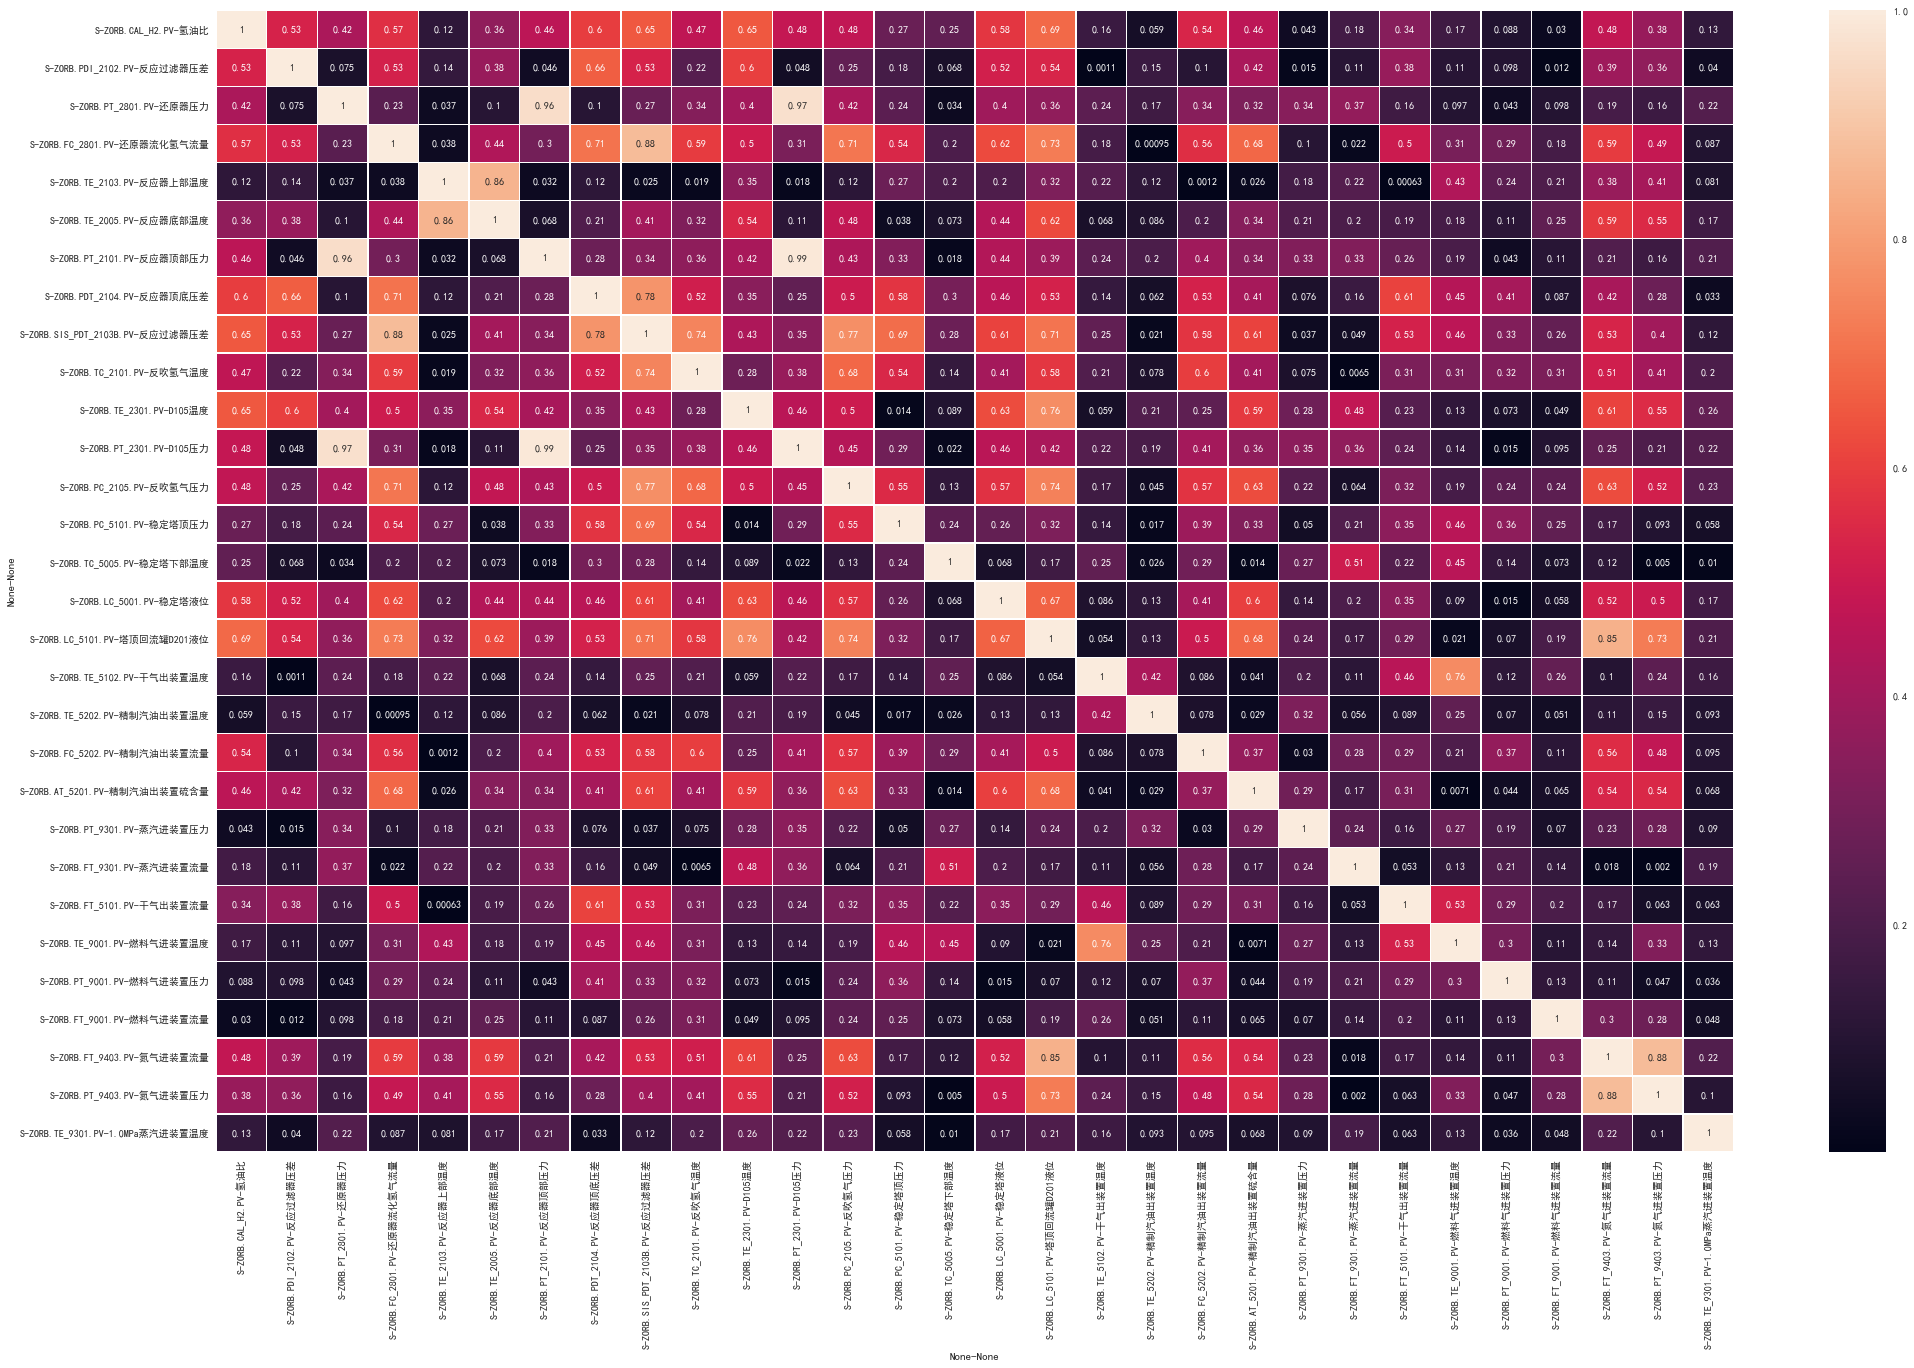

In [5]:
# 计算 操作变量 间的 相关系数 矩阵进行特征选择
manule_features_corr = manule_features.corr(method='spearman').abs()
# 展示 属性间 相关关系 热力图
fig, ax = plt.subplots(figsize=(34, 21))
sns.heatmap(manule_features_corr.iloc[:30, :30], annot=True, linewidths=.5, ax=ax)  # 只取出前 30 个属性作为一个例子

In [6]:
# Upper triangle of correlations
upper = manule_features_corr.where(np.triu(np.ones(manule_features_corr.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 195 columns to remove.


In [7]:
manule_features = manule_features.drop(columns = to_drop)
manule_features.head()

,S-ZORB.CAL_H2.PV,S-ZORB.PDI_2102.PV,S-ZORB.PT_2801.PV,S-ZORB.FC_2801.PV,S-ZORB.TE_2103.PV,S-ZORB.PDT_2104.PV,S-ZORB.TC_2101.PV,S-ZORB.TE_2301.PV,S-ZORB.PC_2105.PV,S-ZORB.PC_5101.PV,...,S-ZORB.TC_3102.DACA,S-ZORB.TE_1102.DACA,S-ZORB.AT-0001.DACA.PV,S-ZORB.AT-0008.DACA.PV,S-ZORB.AT-0012.DACA.PV,S-ZORB.AT-0013.DACA.PV,S-ZORB.FT_1204.DACA.PV,S-ZORB.CAL.LINE.PV,S-ZORB.FT_1503.DACA.PV,S-ZORB.FT_1504.DACA.PV
,氢油比,反应过滤器压差,还原器压力,还原器流化氢气流量,反应器上部温度,反应器顶底压差,反吹氢气温度,D105温度,反吹氢气压力,稳定塔顶压力,...,E-105管程出口管,E-101壳程入口总管温度,S_ZORB AT-0001,S_ZORB AT-0008,S_ZORB AT-0012,S_ZORB AT-0013,D-121含硫污水排量,反应器线速,8.0MPa氢气至循环氢压缩机入口,8.0MPa氢气至反吹氢压缩机出口
324,0.238883,18.426142,2.396758,821.718908,425.160278,57.791767,244.914960,322.651488,5.799387,0.650008,...,230.451200,427.375517,0.556529,0.696293,0.219066,0.383900,2.737464,0.296138,5419704.000,-13900.46050
323,0.235185,18.626541,2.394805,820.887623,426.057338,55.948335,244.818115,332.060390,5.793324,0.650045,...,230.012460,427.996105,0.556830,0.702123,0.226674,0.389345,61.547225,0.296251,4917537.750,-12373.27275
322,0.237478,18.477196,2.398691,818.246100,425.390800,54.764742,245.025612,331.653440,5.780113,0.650000,...,229.862493,428.094835,0.544487,0.700053,0.233229,0.388347,53.357489,0.295287,4415371.475,-10846.08550
321,0.239947,18.356451,2.393195,820.912883,425.062968,54.426241,244.937650,317.072950,5.774570,0.650016,...,228.873972,426.692072,0.535388,0.690537,0.227387,0.387602,76.606090,0.295703,3662122.000,-8555.30420
320,0.238174,18.169647,2.392515,819.708705,424.567210,52.717846,244.986360,335.447328,5.797398,0.650065,...,229.841002,426.765535,0.545854,0.686061,0.252780,0.403654,53.423653,0.295308,3159955.750,-7028.11670


In [8]:
y = produc_features[('产品性质', 'RON损失\n（不是变量）')].to_numpy()
X = manule_features.to_numpy()

In [9]:
# RBF 多项式核 非线性KPCA降维
sigmoid_pca = decomposition.KernelPCA(n_components=30, kernel="sigmoid", fit_inverse_transform=True)
X_reduced_sigmoid = sigmoid_pca.fit_transform(X)
sigmoid_features = pd.DataFrame(data=X_reduced_sigmoid, columns=[f'feature_{x + 1}' for x in range(X_reduced_sigmoid.shape[1])])

sigmoid_features.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# 新特征属性 与 原属性 的 相关系数的阈值
threshold_2 = 0.7

# 根据 新特征属性 与 辛烷值RON损失 的相关系数，筛选 相关系数 小于等于设定阈值的 新特征属性 作为构建函数目标属性
relate_features = set()
for _ in sigmoid_features.keys():
    for __ in manule_features.keys():
        feature_corr = manule_features[__].corr(sigmoid_features[_], method="spearman")
        if np.abs(feature_corr) >= threshold_2:
            relate_features.add(__)
print(relate_features)

set()


In [12]:
kpca_sigmoid_model_features_1st = relate_features
%store kpca_sigmoid_model_features_1st

Stored 'kpca_sigmoid_model_features_1st' (set)
